In [2]:
# Import necessary classes from Qiskit IBM Runtime and Qiskit libraries.
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# (Optional) This line is useful when running in a Jupyter notebook to display plots inline.
%matplotlib inline
 
# Initialize your IBM Quantum Runtime account.
service = QiskitRuntimeService()

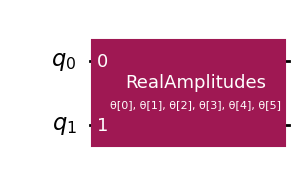

In [3]:
# --- Prepare the Input Circuits and Observable ---
 
# Create a parameterized ansatz circuit using the RealAmplitudes template.
# This circuit will later be used with the Estimator primitive.
psi = RealAmplitudes(num_qubits=2, reps=2)

# Draw the original parameterized circuit.
psi.draw('mpl')
 
# Define an observable as a SparsePauliOp.
# Here the observable is a weighted sum of Pauli operators.
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])

# Define parameter values (angles) to bind to the parameters in the ansatz circuit.
theta = [0, 1, 1, 2, 3, 5]

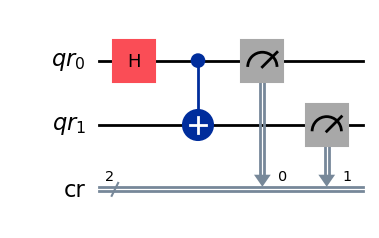

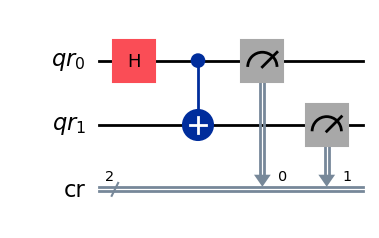

In [4]:
# Create a Bell state circuit:
#   - Define a 2-qubit quantum register and a corresponding 2-bit classical register.
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(2, name="cr")
#   - Create a quantum circuit named "bell" using these registers.
qc = QuantumCircuit(qr, cr, name="bell")
#   - Apply a Hadamard gate to the first qubit to create a superposition.
qc.h(qr[0])
#   - Use a CNOT gate to entangle the first qubit with the second, generating a Bell state.
qc.cx(qr[0], qr[1])
#   - Measure both qubits and store the results in the classical register.
qc.measure(qr, cr)

# Draw the original Bell state circuit.
qc.draw('mpl')

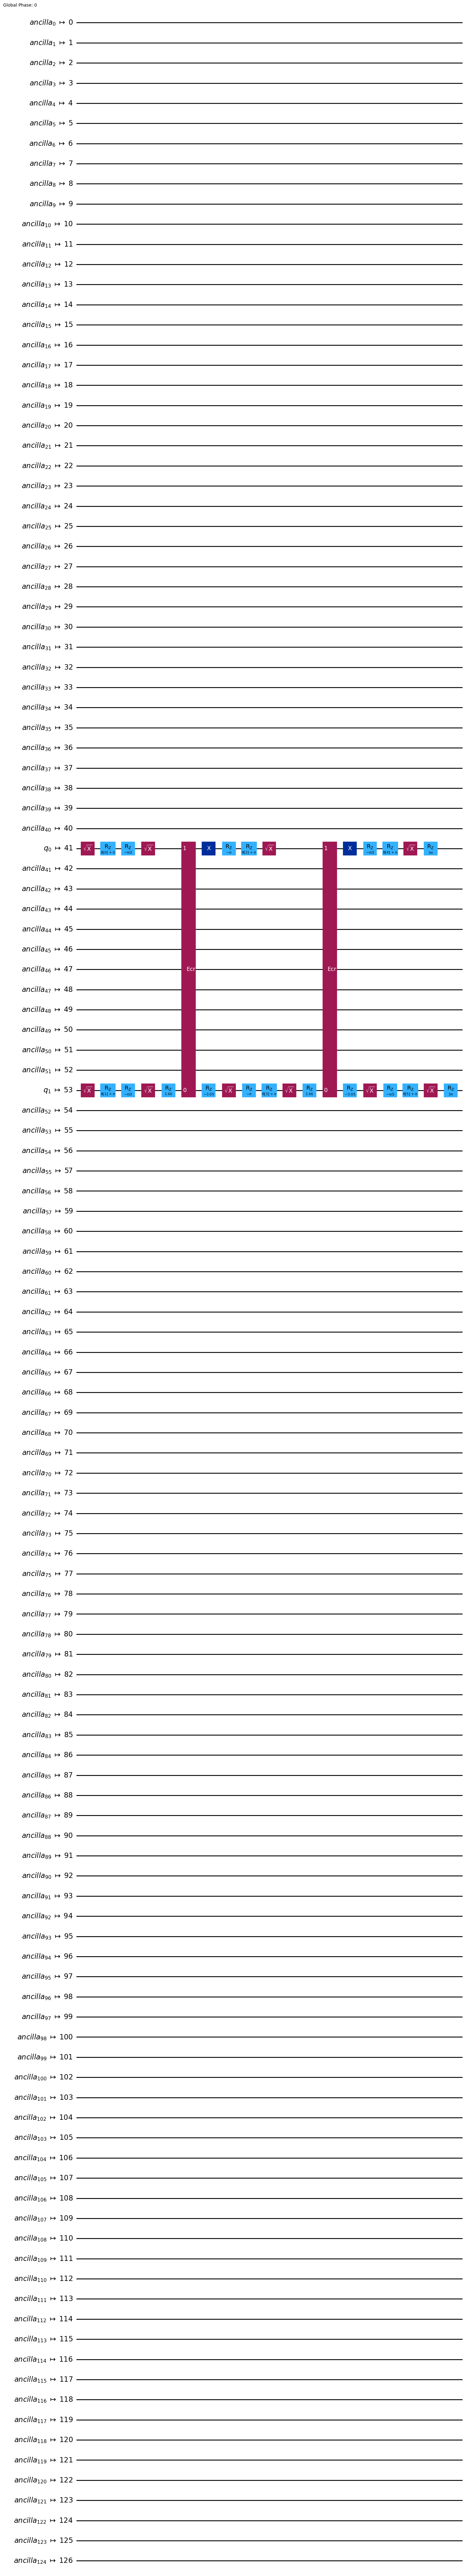

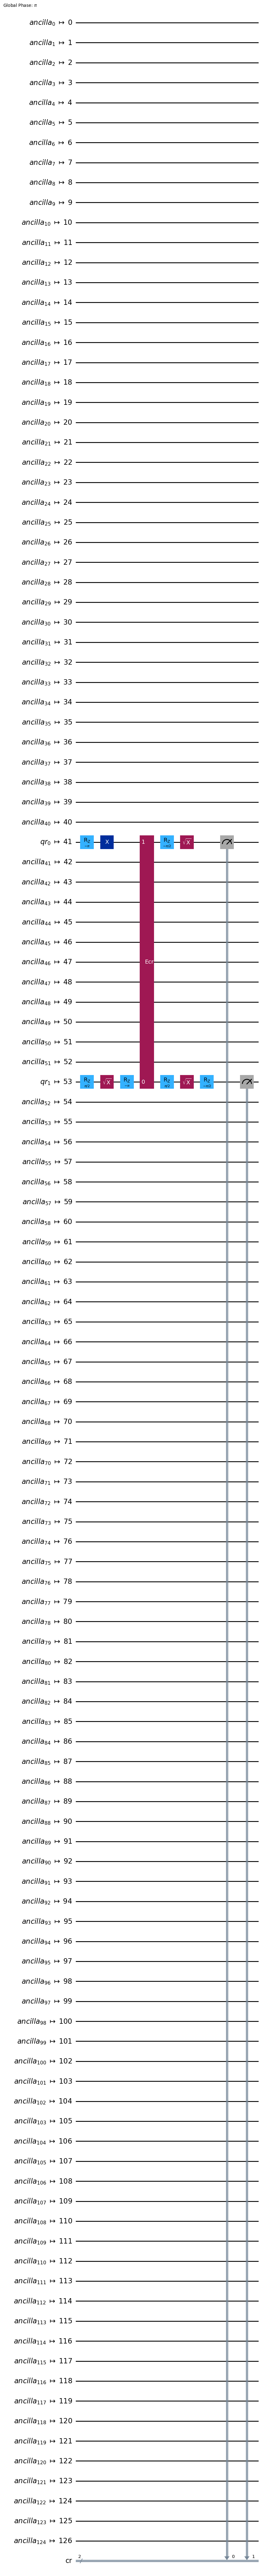

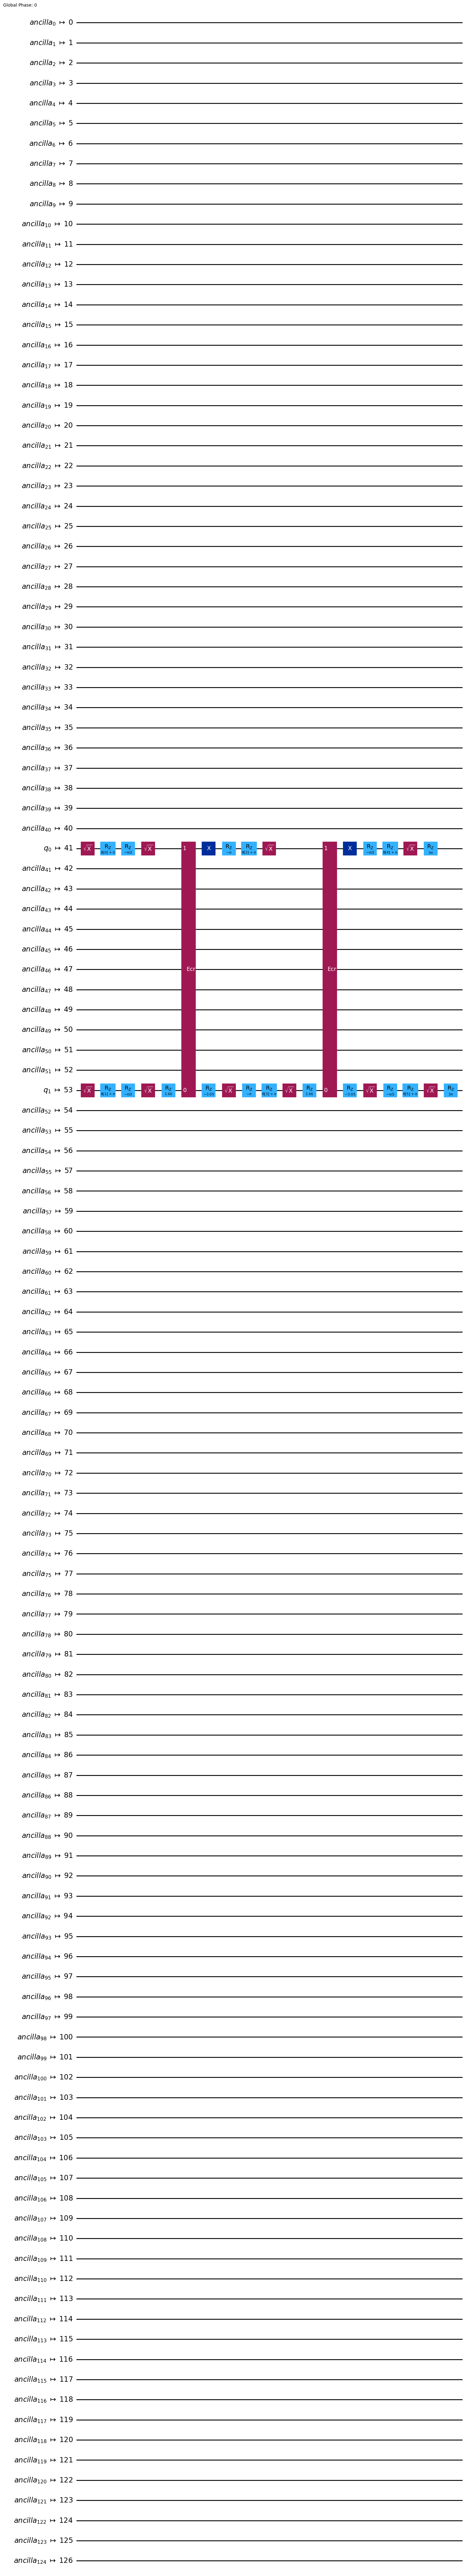

In [7]:
# --- Transpile Circuits for the Selected Backend ---
 
# Select the least busy operational (non-simulator) IBM quantum backend.
backend = service.least_busy(operational=True, simulator=False)
# Generate a preset pass manager tailored to the backend's target ISA with moderate optimization.
pm = generate_preset_pass_manager(target=backend.target)
 
# Transpile the Bell circuit to convert it into the backend's native gate set.
bell_isa_circuit = pm.run(qc)
# Similarly, transpile the parameterized ansatz circuit.
psi_isa_circuit = pm.run(psi)
# Adapt (or "map") the observable to match the qubit layout of the transpiled ansatz circuit.
isa_observables = H1.apply_layout(psi_isa_circuit.layout)

# Draw the transpiled circuits if you want to see how the circuits were transformed.
bell_isa_circuit.draw('mpl')
psi_isa_circuit.draw('mpl')

In [8]:
# --- Run Primitives within a Runtime Session ---
 
# Open a runtime session on the selected backend.
with Session(backend=backend) as session:
    # Create a Sampler primitive instance for sampling measurement outcomes.
    sampler = Sampler(mode=session)
    # Submit the transpiled Bell circuit to the sampler.
    job = sampler.run([bell_isa_circuit])
    # Retrieve the result from the job (first result since we submitted one circuit).
    pub_result = job.result()[0]
    # Print the measurement counts (frequencies of bitstring outcomes).
    print(f"Counts: {pub_result.data.cr.get_counts()}")
 
    # Create an Estimator primitive instance for computing expectation values.
    estimator = Estimator(mode=session)
    # Optionally set error mitigation/resilience level (here set to level 1).
    estimator.options.resilience_level = 1  
    # Run the estimator on a tuple containing:
    #   - the transpiled parameterized circuit,
    #   - the adapted observable,
    #   - the list of parameter values to bind.
    job = estimator.run([(psi_isa_circuit, isa_observables, theta)])
    # Retrieve the expectation value result from the job.
    pub_result = job.result()[0]
    # Print the computed expectation value(s) for the observable.
    print(f"Expectation values: {pub_result.data.evs}")

Counts: {'00': 1984, '11': 2042, '01': 37, '10': 33}


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''